In [2]:
import sys
sys.path.append('..')
import config

from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os               # for reading directories
import seaborn as sns   # for plotting heatmaps

# Connect to MongoDB
client = MongoClient(config.__host, config.__port)

### Init

In [43]:
RESULTS_DIR = "./results_new"
__db_name = "scipub_2"
main_collection_name = "scipub_minimal_venus"
initial_years = [2000, 2004]
influence_years = [2005, 2014]
total_correlations = pd.DataFrame()

def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return

makedir(RESULTS_DIR)
print('Is connection estabilished? {0}'.format(client[__db_name][main_collection_name].count_documents({}) != 0))

Is connection estabilished? True


In [121]:
####################### Select parameters ###########################

#get DataFrame of fit values for each time window
def fit_overview(topic, local_collection):
    pipeline = [
        {'$match': {'overlap': {'$exists': True}}}, 
        {'$project': {'_id':0, topic:1, 'experiment': { '$concat': [ {'$substr': ["$time_window_size", 0, -1 ]}, " - ", {'$substr': ["$overlap", 0, -1 ]}] }, 'overlap': 1, 'time_window_size': 1}} 
    ]
    
    for item in["number_of_new_authors", "number_of_authors", "number_of_papers"]:
        for index, item_2 in enumerate(["a", "b"]):
            pipeline[-1]['$project'][item+"_"+item_2] = {'$arrayElemAt': ['$fit.'+item+'.params', index]}
    
    return pd.DataFrame(list(local_collection.aggregate(pipeline, allowDiskUse=True)))

#get correlations among time windows
def TW_correlations(main_topic, local_collection):
    fit_df = fit_overview(main_topic, local_collection)
    tmp = fit_df[[main_topic, "experiment", "number_of_new_authors_a"]].pivot(index=main_topic, columns="experiment", values="number_of_new_authors_a").dropna(thresh=1)
    print("### Considering the", len(tmp), "items having at least one parameter")
    correlations = []
    for item_1 in tmp.columns:
        list_of_correlations = []
        number_of_items = []
        for item_2 in tmp.columns:
            if item_1 != item_2:
                tmp_loc = tmp[[item_1, item_2]].dropna()
                number_of_items += [len(tmp_loc)]
                list_of_correlations += [tmp_loc[item_1].corr(tmp_loc[item_2], method='spearman')]
        correlations += [{"experiment": item_1, "mean": np.mean(list_of_correlations), "std": np.std(list_of_correlations), "time_window_size": int(item_1[0]), "overlap": int(item_1[-1])}]
    return correlations

#plot heatmap
def plot_heatmap(df, use_index=False, type=None, highlight_diagonal=True, show_values=False, fmt = '.0f', cbar=True, columns=None, partitions=[], figsize=(8,8), filename=""):
    fig = plt.figure(figsize = figsize)
    sns.set(font_scale=1.2, style="white")
    
    mask = np.zeros_like(np.array(df))
    if type == "diag":
        mask[np.diag_indices_from(mask)] = True
    elif type == "upper":
        mask[np.triu_indices_from(mask)] = True
        mask[np.diag_indices_from(mask)] = False
    elif type == "lower":
        mask[np.tril_indices_from(mask)] = True
    
    to_plot = df.copy()
    if use_index:
        ax = sns.heatmap(to_plot, square=1, linewidth=1., mask=mask, annot=show_values, fmt = fmt, cmap="Greens", cbar=cbar)#, xticklabels=ticklabels, yticklabels=ticklabels)
    else:
        ax = sns.heatmap(to_plot[to_plot.columns[1:]], square=1, linewidth=1., vmin=0, mask=mask, annot=show_values, fmt = fmt, cmap="Greens")#, xticklabels=ticklabels, yticklabels=ticklabels)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    if highlight_diagonal:
        number_of_items = len(df)
        for index in range(number_of_items):
            ax.add_patch(Rectangle((number_of_items-index-1, index), 1, 1, fill=False, edgecolor='lightgrey', lw=2))
    #highlight partitions
    if partitions:
        for partition in partitions:
            ax.add_patch(Rectangle((partition[0], len(to_plot)-partition[1]-1), (partition[1] - partition[0] + 1), (partition[1] - partition[0] + 1), fill=False, edgecolor='black', lw=2))
    
    ax.set(title='', xlabel=r'Length of Overlap ($\gamma$)', ylabel=r'Length of Time Window ($\delta$)')
    
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    #plot
    plt.show()
    return

####################### Get scores ###########################

def get_authors_score(param_name, param_index, time_window_size, overlap, topic, N, local_collection):
    pipeline = [
        { '$match': {'time_window_size': time_window_size, 'overlap': overlap} },
        { '$project': {'_id':0, topic:1, 'param': { "$arrayElemAt": [ '$fit.'+param_name+'.params', param_index ]}, 'overlap': 1, 'time_window_size': 1, 'h_index': 1, 'h_index_local': 1, 'g_index': 1, 'g_index_local': 1, 'i'+str(N)+'_index': 1, 'i'+str(N)+'_index_local': 1, 'm_index': 1, 'm_index_local': 1} },
        { '$sort' : {'param': -1}}
    ]
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#papers written by a list of authors, with the year of first (or last) publication
def list_of_authors(list_of_papers=None, range_of_years=None, local_collection=main_collection_name):
    
    #order_year = -1 if last else 1
    pipeline = [
            {'$project': {'_id' :0, 'authors': 1, 'year': 1}},
            {'$unwind': '$authors'}, 
            {'$sort': {'authors': 1, 'year': 1}},
            {'$group': {'_id' : '$authors', 'year_first': {'$first': '$year'}, 'year_last': {'$last': '$year'} }},
            {'$project': {'_id' :0, 'author': '$_id', 'year_first': '$year_first', 'year_last': '$year_last', 'range_of_years': {'$subtract': [ "$year_last", "$year_first" ]} }},
    ]

    if range_of_years != None:
        pipeline = [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline

    if list_of_papers != None:
        pipeline = [
                    {'$match': {'_id': {'$in': list_of_papers}}}, 
        ] + pipeline
        
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#number of papers written by each author
def number_of_papers(range_of_years=None, local_collection=main_collection_name):
    pipeline = [
            {'$project': {'_id' :0, 'authors': 1, 'year': 1}},
            {'$unwind': '$authors'}, 
            {'$group': {'_id' : '$authors', 'count': { '$sum': 1 }}},
            {'$project': {'_id' :0, 'author': '$_id', 'count': '$count'}},
    ]

    if range_of_years != None:
        pipeline = [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline
        
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#calculate scores of authors
def get_score_authors(main_topic, best_parameters, N, __db_name, main_collection_name, experiment_collection_name):
    tmp = pd.DataFrame(list(get_authors_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, N, local_collection=client[__db_name][experiment_collection_name]))).rename(columns={main_topic: "author"})
    #range of years - total
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(local_collection=client[__db_name][main_collection_name]))), how="left")
    #range of years - only in the time window under study
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"year_first": "year_first_local", "year_last": "year_last_local", "range_of_years": "range_of_years_local"}), how="left")
    #number of publications - total
    tmp = tmp.merge(pd.DataFrame(list(number_of_papers(local_collection=client[__db_name][main_collection_name]))).rename(columns={"count": "number_of_papers"}), how="left")
    #number of publications - only in the time window under study
    tmp = tmp.merge(pd.DataFrame(list(number_of_papers(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"count": "number_of_papers_local"}), how="left")
    return tmp

#get our scores on fit
def get_fit_score(param_name, param_index, time_window_size, overlap, topic, local_collection):
    pipeline = [
        { '$match': {'time_window_size': time_window_size, 'overlap': overlap} },
        { '$project': {'_id':0, topic:1, 'param': { "$arrayElemAt": [ '$fit.'+param_name+'.params', param_index ]}, 'overlap': 1, 'time_window_size': 1, 'h_index': 1, 'h_index_local': 1} },
        { '$sort' : {'param': -1}}
    ]
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#calculate scores of publications
def get_score_papers(main_topic, best_parameters, __db_name, main_collection_name, experiment_collection_name):
    #get score for each paper
    tmp = pd.DataFrame(list(get_fit_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, local_collection=client[__db_name][experiment_collection_name])))[[main_topic, "param"]].rename(columns={main_topic: '_id'})
    #get authors and number of citations for each paper
    tmp = tmp.merge(pd.DataFrame(list(client[__db_name][main_collection_name].aggregate([
        {'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]} }}, 
        {'$project': {'_id': 1, 'authors': 1, 'number_of_citations': { '$size': '$acm_cited_by' } }}, 
        {'$unwind': '$authors' }, 
    ]))).rename(columns={'authors': 'author'}), how="left")
    #get range of years of publication for each author
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(local_collection=client[__db_name][main_collection_name])))[["author", "range_of_years"]], how="left")
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"range_of_years": "range_of_years_local"})[["author", "range_of_years_local"]], how="left")
    #get h-index for each author
    tmp = tmp.merge(
        pd.DataFrame(list(client[__db_name][main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+"authors"].aggregate([
            {'$project': { '_id': 0, 'authors': 1, 'h_index': 1, 'h_index_local': 1 }},
            {'$group': { '_id': '$authors', 'h_index': {'$first': '$h_index'}, 'h_index_local': {'$first': '$h_index_local'} }},
            {'$project': { '_id': 0, 'author': '$_id', 'h_index': 1, 'h_index_local': 1 }},
        ])))
    , how="left")
    #for each publication, keep only the max value of each feature calculted on its authors
    tmp = tmp.drop(columns=["author"]).groupby("_id").max().reset_index()
    #add titles
    tmp = pd.DataFrame(list(client[__db_name][main_collection_name].find({},{ '_id': 1, 'title': 1}))).merge(tmp, how="right")
    return tmp.sort_values(by="param", ascending=False).reset_index(drop=True)

#calculate the number of citations received by a field
def get_number_citations_received(field_name, range_of_years, local_collection):
    pipeline = [
            {'$project': { '_id': 0, field_name: 1, 'acm_cited_by': 1 }},
            {'$unwind': '$acm_cited_by' },
            {'$project': { field_name: 1, 'year_of_citation': '$acm_cited_by.year' }},
            {'$match': { 'year_of_citation': {'$gte': range_of_years[0], '$lte': range_of_years[1]} }}, 
            {'$group': { '_id': '$'+field_name, 'count': { '$sum': 1} }}, 
            {'$project': { '_id': 0, field_name: '$_id', 'citations_received': '$count' }},
            {'$sort': { 'citations_received': -1 }},
    ]
    return local_collection.aggregate(pipeline)

#calculate scores of venues
def get_score_venues(main_topic, best_parameters, __db_name, main_collection_name, experiment_collection_name):
    tmp = pd.DataFrame(list(get_fit_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, local_collection=client[__db_name][experiment_collection_name])))[[main_topic, "param"]]#.sort_values(by="param", ascending=False)
    tmp = tmp.merge(pd.DataFrame(list(get_number_citations_received("venue", influence_years, local_collection=client[__db_name][main_collection_name]))), how="outer")#.fillna(0)
    #add number of paper published by each journal/conference in initial_years
    tmp = tmp.merge(pd.DataFrame(list(client[__db_name][experiment_collection_name].aggregate([
        {'$match': {'time_window_size': best_parameters[0], 'overlap': best_parameters[1] }},
        {'$project': {'_id':0, 'venue': 1, 'number_of_published_papers': { '$arrayElemAt': [ '$number_of_papers', 0 ]} }},
        {'$match': {'number_of_published_papers': { '$exists' :True} }},
    ]))),
             how="left")
    #add a calculation similar to citescore: https://www.elsevier.com/editors-update/story/journal-metrics/citescore-a-new-metric-to-help-you-choose-the-right-journal
    tmp["custom_citescore"] = tmp["citations_received"]/(tmp["number_of_published_papers"]*(influence_years[1] - influence_years[0] + 1))
    return tmp

#calculate the number of citations received by a topic
def get_number_citations_received_topic(threshold, years_cited, years_citing, local_collection):
    pipeline = [
            {'$match': { 'year': {'$gte': years_cited[0], '$lte': years_cited[1]} }},
            {'$project': { '_id': 0, 'topics': 1, 'acm_cited_by': 1 }},
            {'$unwind': '$topics' }, 
            {'$match': { 'topics.weight': {'$gte': threshold} }},
            {'$unwind': '$acm_cited_by' },
            {'$project': { 'topics': '$topics.id', 'year_of_citation': '$acm_cited_by.year' }},
            {'$match': { 'year_of_citation': {'$gte': years_citing[0], '$lte': years_citing[1]} }}, 
            {'$group': { '_id': '$topics', 'count': { '$sum': 1} }}, 
            {'$project': { '_id': 0, 'topics': '$_id', 'citations_received': '$count' }},
            {'$sort': { 'citations_received': -1 }},
    ]
    return local_collection.aggregate(pipeline)

#calculate the number of publications on a topic
def get_number_publications_topic(threshold, range_of_years, local_collection):
    pipeline = [
            {'$match': { 'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]} }},
            {'$project': { '_id': 0, 'topics': 1 }},
            {'$unwind': '$topics' }, 
            {'$match': { 'topics.weight': {'$gte': threshold} }},
            {'$project': { 'topics': '$topics.id' }},
            {'$group': { '_id': '$topics', 'count': { '$sum': 1} }}, 
            {'$project': { '_id': 0, 'topics': '$_id', 'publications': '$count' }},
            {'$sort': { 'publications': -1 }},
    ]
    return local_collection.aggregate(pipeline)

#get the other score on a topic
def get_topics_score_diffusion(param_name, param_index, field_name, local_collection):
    pipeline = [
        { '$match': { 'diffusion-fit': {'$exists': True}} },
        { '$group': { '_id': "$"+field_name, 'param': {'$first': { "$arrayElemAt": [ '$diffusion-fit.'+param_name+'.params', param_index ]}}} },
        { '$project': {'_id':0, field_name: "$_id", 'param': 1 } },
        { '$sort' : {'param': -1}}
    ]
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#calculate scores of topics
def get_score_topics(field_name, topic_threshold, best_parameters, __db_name, main_collection_name, experiment_collection_name):
    tmp = pd.DataFrame(list(get_fit_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], field_name, local_collection=client[__db_name][experiment_collection_name])))[[field_name, "param"]]#.sort_values(by="param", ascending=False)
    tmp = tmp.merge(pd.DataFrame(list(get_number_citations_received_topic(topic_threshold, initial_years, influence_years, local_collection=client[__db_name][main_collection_name]))), how="outer")#.fillna(0)
    tmp = tmp.merge(pd.DataFrame(list(get_number_publications_topic(topic_threshold, initial_years, local_collection=client[__db_name][main_collection_name]))).rename(columns={"publications": "publications_initial"}), how="outer")#.fillna(0)
    tmp = tmp.merge(pd.DataFrame(list(get_number_publications_topic(topic_threshold, influence_years, local_collection=client[__db_name][main_collection_name]))).rename(columns={"publications": "publications_other"}), how="outer")#.fillna(0)
    tmp = tmp.merge(pd.DataFrame(list(get_topics_score_diffusion("number_of_new_authors", 0, field_name, local_collection=client[__db_name][experiment_collection_name])))[[field_name, "param"]].rename(columns={"param": "diffusion"}))
    return tmp

####################### Get correlations ###########################

def get_correlations_dict_authors(df, iN_index_score):
    res = []
    ####
    item_1 = "range_of_years_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "range_of_years_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "param", "value": corr, "item": "Authors"}]
    ####
    item_1 = "number_of_papers_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "number_of_papers_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "param", "value": corr, "item": "Authors"}]
    ####
    item_1 = "g_index_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "g-index", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "g_index_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "g-index", "score": "param", "value": corr, "item": "Authors"}]
    ####
    item_1 = "m_index_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "m-index", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "m_index_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "m-index", "score": "param", "value": corr, "item": "Authors"}]
    ####
    item_1 = "i"+str(iN_index_score)+"_index_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "i"+str(iN_index_score)+"-index", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "i"+str(iN_index_score)+"_index_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "i"+str(iN_index_score)+"-index", "score": "param", "value": corr, "item": "Authors"}]
    return res

def get_correlations_dict_papers(df):
    res = []
    ####
    item_1 = "range_of_years_local"; item_2 = "number_of_citations"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "h-index", "value": corr, "item": "Documents"}]
    ####
    item_1 = "range_of_years_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "param", "value": corr, "item": "Documents"}]
    ####
    item_1 = "h_index_local"; item_2 = "number_of_citations"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "h-index", "score": "h-index", "value": corr, "item": "Documents"}]
    ####
    item_1 = "h_index_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "h-index", "score": "param", "value": corr, "item": "Documents"}]
    return res

def get_correlations_dict_venues(df):
    res = []
    ####
    item_1 = "citations_received"; item_2 = "custom_citescore"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of references", "score": "Impact Factor", "value": corr, "item": "Venues"}]
    ####
    item_1 = "citations_received"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of references", "score": "param", "value": corr, "item": "Venues"}]
    ####
    item_1 = "number_of_published_papers"; item_2 = "custom_citescore"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "Impact Factor", "value": corr, "item": "Venues"}]
    ####
    item_1 = "number_of_published_papers"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "param", "value": corr, "item": "Venues"}]
    return res

def get_correlations_dict_topics(df):
    res = []
    ####
    item_1 = "publications_initial"; item_2 = "diffusion" #"citations_received"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T_0$", "score": "Num. of references", "value": corr, "item": "Topics"}]
    ####
    item_1 = "publications_initial"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T_0$", "score": "param", "value": corr, "item": "Topics"}]
    ####
    item_1 = "publications_other"; item_2 = "diffusion" #"citations_received"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T'$", "score": "Num. of references", "value": corr, "item": "Topics"}]
    ####
    item_1 = "publications_other"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T'$", "score": "param", "value": corr, "item": "Topics"}]
    return res

####################### Plot correlations ###########################

def plot_local(df, number_of_items):
    fig = plt.figure(figsize = (3,4))
    ax = plt.gca()
    for score in df["score"].unique():
        to_plot = df[df["score"] == score]
        color = "grey" if (score != "param") else "royalblue"
        label = score if (score != "param") else "our"
        plt.plot(range(len(to_plot)), to_plot["value"], linewidth=2, color=color)#, xticklabel=to_plot["feature"])
        shift = 0 if (score != "param") else 0.01
        ax.text(len(to_plot)-0.9, list(to_plot["value"])[-1]-shift, label, weight='bold', ha="left", color=color, size=12) #ax.text(len(to_plot)+0.2, to_plot["value"][-1], label, ha="center") 
    plt.xticks(range(len(to_plot)), to_plot["feature"], rotation='vertical')
    if ax.get_ylim()[0] > 0:
        ax.set_ylim([0,ax.get_ylim()[1]])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("Spearman correlation\n-for "+str(number_of_items)+" items-")
    plt.show()
    return

def plot_correlations(df):
    fig = plt.figure(figsize = (3,4))
    ax = plt.gca()
    for score in df["score"].unique():
        to_plot = df[df["score"] == score]
        color = "grey" if (score != "param") else "royalblue"
        label = "baseline" if (score != "param") else "our"
        plt.plot(to_plot["value"], range(len(to_plot)), 'o', color=color)
    plt.yticks(range(len(to_plot)), to_plot["feature"])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("Spearman correlation")
    plt.show()
    return

def plot_correlations_2(df, vertical=True, filename=""):
    fig = plt.figure(figsize = (8,4))
    ax = plt.gca()
    for score in df["score"].unique():
        #print(score)
        to_plot = df[df["score"] == score]
        color = "grey" if (score != "param") else "royalblue"
        label = "baseline" if (score != "param") else "our"
        if vertical:
            plt.plot(range(len(to_plot)), to_plot["value"], 'o', markersize=8, color=color, label=label)
        else:
            plt.plot(to_plot["value"], range(len(to_plot)), 'o', markersize=8, color=color, label=label)
    if vertical:
        plt.xticks(range(len(to_plot)), to_plot["feature"], rotation='vertical', fontsize=14)
        ax.yaxis.set_tick_params(labelsize=14)
    else:
        plt.yticks(range(len(to_plot)), to_plot["feature"], fontsize=14)
        ax.xaxis.set_tick_params(labelsize=14)
        
    #background
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    if vertical:
        for index, item in enumerate(df["item"].unique()):
            limits = [total_correlations[total_correlations["item"] == item].index.min()/2 - 0.5, total_correlations[total_correlations["item"] == item].index.max()/2]
            ax.fill_between([limits[0], limits[0] + (limits[1] - limits[0])], ax.get_ylim()[0], ax.get_ylim()[1], facecolor=['#ededed', 'white'][index%2])#, alpha=0.1)
            ax.text(limits[0] + (limits[1] - limits[0])/2, ylim[1], item+"\n ", weight='bold', ha="center", color=['black','grey'][index%2], size=16) #ax.text(len(to_plot)+0.2, to_plot["value"][-1], label, ha="center") 
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 14})
    else:
        for index, item in enumerate(df["item"].unique()):
            limits = [total_correlations[total_correlations["item"] == item].index.min()/2 - 0.5, total_correlations[total_correlations["item"] == item].index.max()/2]
            ax.fill_between(xlim, limits[0], limits[1], facecolor=['#ededed', 'white'][index%2])#, alpha=0.1)
            ax.text(xlim[1], limits[0] + (limits[1] - limits[0])/2, "  "+item, weight='bold', ha="left", color=['black','grey'][index%2], size=16) #ax.text(len(to_plot)+0.2, to_plot["value"][-1], label, ha="center") 
        plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0., prop={'size': 14})
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    #style
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    #plot
    plt.show()
    return


## Analyze authors

In [122]:
field_name = "authors"
iN_index_score = 10

experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name

'scipub_minimal_venus-experiment-2000_2004-2005_2014-authors'

### Considering the 18254 items having at least one parameter

MAX: {'experiment': '5 - 3', 'mean': 0.8918061685942581, 'std': 0.0841574616683597, 'time_window_size': 5, 'overlap': 3}


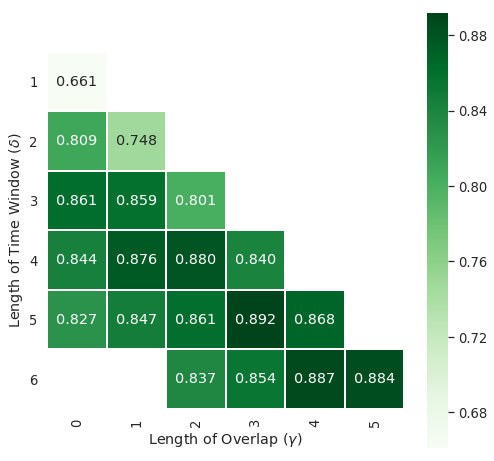

In [123]:
correlations = TW_correlations(field_name, client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp)
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".jpg")


In [46]:
score_authors = get_score_authors(field_name, best_parameters, iN_index_score, __db_name, main_collection_name, experiment_collection_name)


In [47]:
print("Top authors, over", len(score_authors.dropna()), "authors, according to our method")
score_authors.sort_values(by=["param","number_of_papers_local"], ascending=[False, True])[:60]

Top authors, over 16245 authors, according to our method


,author,g_index,g_index_local,h_index,h_index_local,i10_index,i10_index_local,m_index,m_index_local,overlap,param,time_window_size,range_of_years,year_first,year_last,range_of_years_local,year_first_local,year_last_local,number_of_papers,number_of_papers_local
0,Michael I. Jordan,48,46,17,16,24,22,39.0,37.0,3,4966.999991,5,24,1991,2015,14,2000,2014,72,57
1,Pedro Domingos,36,33,18,16,25,22,32.5,32.5,3,4432.499974,5,17,1995,2012,12,2000,2012,43,38
2,Wei-Ying Ma,40,37,25,25,60,57,44.0,38.0,3,4271.000015,5,19,1996,2015,13,2001,2014,149,145
3,Jiawei Han,54,50,32,30,114,107,51.0,40.5,3,4205.000013,5,26,1989,2015,14,2000,2014,353,327
4,Christos Faloutsos,45,38,28,26,55,46,46.0,42.0,3,4116.999958,5,30,1985,2015,14,2000,2014,219,193
5,George Karypis,33,28,14,14,26,23,39.5,30.5,3,4066.000000,5,17,1998,2015,13,2000,2013,52,48
6,ChengXiang Zhai,45,45,25,25,43,43,50.0,50.0,3,3887.499990,5,13,2001,2014,13,2001,2014,115,115
7,Thorsten Joachims,40,35,16,16,19,19,81.0,81.0,3,3868.499995,5,17,1998,2015,12,2002,2014,40,36
8,Raymond J. Mooney,29,27,14,13,20,17,40.5,26.0,3,3795.999984,5,26,1985,2011,10,2001,2011,55,36
9,Andrew Y. Ng,38,30,13,12,16,14,20.0,22.0,3,3743.500014,5,16,1997,2013,12,2001,2013,40,38


In [48]:
print("Top authors, over", len(score_authors.dropna()), "authors, according to h-index")
score_authors.sort_values(by=["h_index_local","number_of_papers_local"], ascending=[False, True])[:60]

Top authors, over 16245 authors, according to h-index


,author,g_index,g_index_local,h_index,h_index_local,i10_index,i10_index_local,m_index,m_index_local,overlap,param,time_window_size,range_of_years,year_first,year_last,range_of_years_local,year_first_local,year_last_local,number_of_papers,number_of_papers_local
3,Jiawei Han,54,50,32,30,114,107,51.0,40.5,3,4205.000013,5,26,1989,2015,14,2000,2014,353,327
4,Christos Faloutsos,45,38,28,26,55,46,46.0,42.0,3,4116.999958,5,30,1985,2015,14,2000,2014,219,193
6,ChengXiang Zhai,45,45,25,25,43,43,50.0,50.0,3,3887.499990,5,13,2001,2014,13,2001,2014,115,115
2,Wei-Ying Ma,40,37,25,25,60,57,44.0,38.0,3,4271.000015,5,19,1996,2015,13,2001,2014,149,145
29,Philip S. Yu,44,40,26,25,88,80,49.0,44.0,3,3034.500000,5,28,1987,2015,14,2000,2014,363,326
49,W. Bruce Croft,41,39,26,24,50,45,48.0,46.5,3,2630.500008,5,36,1978,2014,14,2000,2014,132,110
133,Alon Y. Halevy,35,35,22,22,35,35,40.0,40.0,3,1973.500008,5,15,2000,2015,14,2000,2014,73,72
92,Jian Pei,37,37,22,22,42,42,42.5,42.5,3,2245.999994,5,15,2000,2015,14,2000,2014,153,151
369,Qiang Yang 0001,35,35,21,21,49,49,30.0,30.0,3,1276.000001,5,26,1989,2015,14,2000,2014,201,190
84,Eamonn J. Keogh,33,33,20,20,31,31,43.5,43.5,3,2350.500012,5,18,1997,2015,14,2000,2014,96,93


Spearman correlation with h-index_local: 0.45071009985214533


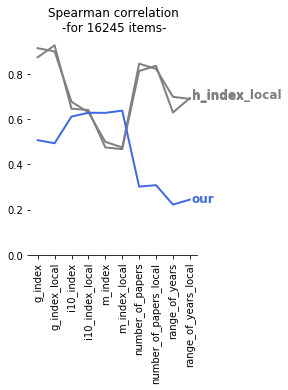

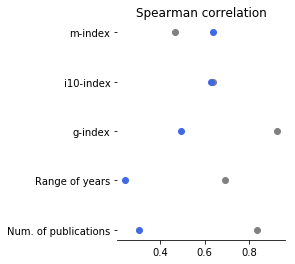

,feature,score,value
0,range_of_years,h_index_local,0.628437
1,range_of_years,h_index,0.697909
2,range_of_years,param,0.221776
3,number_of_papers,h_index_local,0.811795
4,number_of_papers,h_index,0.844186
5,number_of_papers,param,0.301200
6,g_index,h_index_local,0.872187
7,g_index,h_index,0.912640
8,g_index,param,0.506188
9,m_index,h_index_local,0.474286


In [49]:
print("Spearman correlation with h-index_local:",
      score_authors.dropna()["param"].corr(score_authors.dropna()["h_index_local"], method='spearman'))

res = []
for item_1 in ["range_of_years", "number_of_papers", "g_index", "m_index", "i"+str(iN_index_score)+"_index", "range_of_years_local", "number_of_papers_local", "g_index_local", "m_index_local", "i"+str(iN_index_score)+"_index_local"]:#["year_first", "year_first_local", ]
    for item_2 in ["h_index_local", "h_index", "param"]:
        tmp_local = score_authors.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_authors.dropna()))
plot_correlations(pd.DataFrame(get_correlations_dict_authors(score_authors, iN_index_score)).sort_values(by="feature"))

total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict_authors(score_authors, iN_index_score)))
pd.DataFrame(res)


## Analyze publications

In [124]:
field_name = "acm_id"

experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name


'scipub_minimal_venus-experiment-2000_2004-2005_2014-acm_id'

### Considering the 11417 items having at least one parameter

MAX: {'experiment': '5 - 3', 'mean': 0.8759015231062612, 'std': 0.09818075052789958, 'time_window_size': 5, 'overlap': 3}


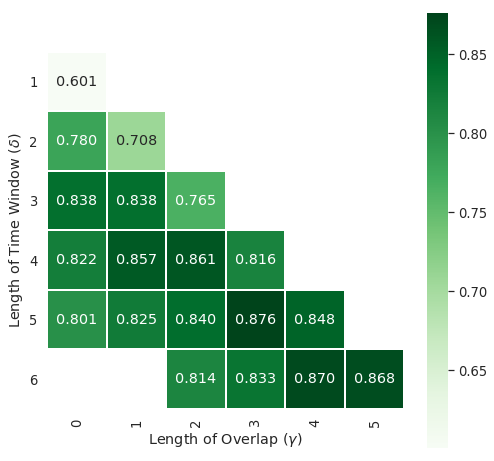

In [125]:
correlations = TW_correlations(field_name, client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp)
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".jpg")


In [52]:
score_papers = get_score_papers(field_name, best_parameters, __db_name, main_collection_name, experiment_collection_name)


In [53]:
print("Top Documents by our method")
score_papers[["_id","param"]].merge(pd.DataFrame(list(client[config.__db_name]["dblp_papers"].aggregate([{'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]} }},{'$project': { '_id': 0, 'acm_id': 1, 'title': 1, 'authors': 1 }}]))), left_on="_id", right_on="acm_id").sort_values(by="param", ascending=False)[["acm_id", "title", "authors", "param"]][:40]


Top Documents by our method


,acm_id,title,authors,param
0,53908b4920f70186a0dbc3df,Optimizing search engines using clickthrough d...,[Thorsten Joachims],3558.000005
1,5390958920f70186a0deea5b,Latent Dirichlet Allocation.,"[David M. Blei, Andrew Y. Ng, Michael I. Jordan]",3097.499997
2,5390880720f70186a0d78970,Text Classification from Labeled and Unlabeled...,"[Kamal Nigam, Andrew McCallum, Sebastian Thrun...",3074.999995
3,5390881720f70186a0d80bfc,Machine learning in automated text categorizat...,[Fabrizio Sebastiani 0001],2778.500001
4,5390880220f70186a0d781e4,IR evaluation methods for retrieving highly re...,"[Kalervo Järvelin, Jaana Kekäläinen]",2482.500015
5,539096cb20f70186a0df79e8,Web-scale information extraction in knowitall:...,"[Oren Etzioni, Michael J. Cafarella, Doug Down...",2378.499997
6,5390972920f70186a0dfa5ea,RCV1: A New Benchmark Collection for Text Cate...,"[David D. Lewis, Yiming Yang, Tony G. Rose, Fa...",2304.499999
7,5390958920f70186a0deea74,An Introduction to Variable and Feature Select...,"[Isabelle Guyon, André Elisseeff]",2286.499993
8,5390881720f70186a0d7fe20,"Document Language Models, Query Models, and Ri...","[John D. Lafferty, ChengXiang Zhai]",2202.000009
9,539095ba20f70186a0df1b31,Latent semantic models for collaborative filte...,[Thomas Hofmann],1950.499991


In [54]:
print("Top Documents by number of citations received")
score_papers[["_id","number_of_citations"]].merge(pd.DataFrame(list(client[config.__db_name]["dblp_papers"].aggregate([{'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]} }},{'$project': { '_id': 0, 'acm_id': 1, 'title': 1, 'authors': 1 }}]))), left_on="_id", right_on="acm_id").sort_values(by="number_of_citations", ascending=False)[["acm_id", "title", "authors", "number_of_citations"]][:40]


Top Documents by number of citations received


,acm_id,title,authors,number_of_citations
1,5390958920f70186a0deea5b,Latent Dirichlet Allocation.,"[David M. Blei, Andrew Y. Ng, Michael I. Jordan]",1122.0
0,53908b4920f70186a0dbc3df,Optimizing search engines using clickthrough d...,[Thorsten Joachims],564.0
15,539088b820f70186a0d8f6a0,Random Forests.,[Leo Breiman],547.0
3,5390881720f70186a0d80bfc,Machine learning in automated text categorizat...,[Fabrizio Sebastiani 0001],490.0
7,5390958920f70186a0deea74,An Introduction to Variable and Feature Select...,"[Isabelle Guyon, André Elisseeff]",473.0
12,5390880720f70186a0d7a7be,Content-Based Image Retrieval at the End of th...,"[Arnold W. M. Smeulders, Marcel Worring, Simon...",446.0
28,5390893e20f70186a0d9292c,Cumulated gain-based evaluation of IR techniques.,"[Kalervo Järvelin, Jaana Kekäläinen]",441.0
11,539095ba20f70186a0df1b2f,Evaluating collaborative filtering recommender...,"[Jonathan L. Herlocker, Joseph A. Konstan, Lor...",370.0
10,53908b9320f70186a0dc040d,Laplacian Eigenmaps for Dimensionality Reducti...,"[Mikhail Belkin, Partha Niyogi]",346.0
53,53908b4920f70186a0dbb0b1,A survey of approaches to automatic schema mat...,"[Erhard Rahm, Philip A. Bernstein]",339.0


Spearman correlation with number of references: 0.646562992536473


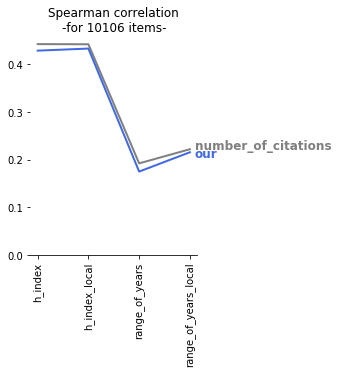

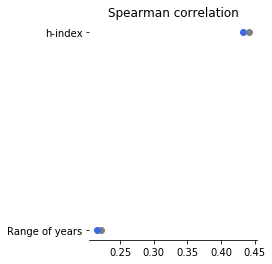

,feature,score,value
0,h_index_local,number_of_citations,0.442061
1,h_index_local,param,0.433028
2,h_index,number_of_citations,0.442382
3,h_index,param,0.428691
4,range_of_years_local,number_of_citations,0.222053
5,range_of_years_local,param,0.215685
6,range_of_years,number_of_citations,0.192455
7,range_of_years,param,0.175240


In [55]:
print("Spearman correlation with number of references:",
      score_papers.dropna()["param"].corr(score_papers.dropna()["number_of_citations"], method='spearman'))
res = []
for item_1 in ["h_index_local", "h_index", "range_of_years_local", "range_of_years"]:#["year_first", "year_first_local", ]
    for item_2 in ["number_of_citations", "param"]:
        tmp_local = score_papers.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_papers.dropna()))
plot_correlations(pd.DataFrame(get_correlations_dict_papers(score_papers)).sort_values(by="feature"))

total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict_papers(score_papers)))
pd.DataFrame(res)


## Analyze venues

In [126]:
field_name = "venue"
experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name


'scipub_minimal_venus-experiment-2000_2004-2005_2014-venue'

### Considering the 118 items having at least one parameter

MAX: {'experiment': '4 - 2', 'mean': 0.9562371146330718, 'std': 0.05159329008268681, 'time_window_size': 4, 'overlap': 2}


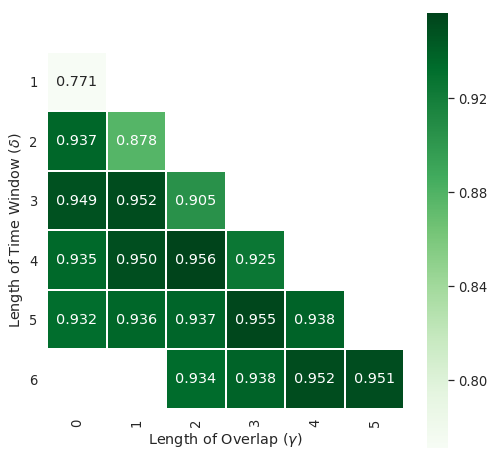

In [127]:
correlations = TW_correlations(field_name, client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp)
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".jpg")


In [58]:
score_venues = get_score_venues(field_name, best_parameters, __db_name, main_collection_name, experiment_collection_name)


In [59]:
print("Top Venues according to our method")
score_venues.sort_values(by="param", ascending=False)[["venue", "param", "custom_citescore"]][:25]

Top Venues according to our method


,venue,param,custom_citescore
0,kdd,7663.999997,4.644172
1,machine learning,7119.699973,4.881481
2,journal of machine learning research,7052.199975,6.422527
3,ieee trans. knowl. data eng,6651.199991,2.349465
4,cikm,6497.800009,2.983582
5,icdm,6413.399993,1.510526
6,sigir,6332.400000,5.120166
7,ieee trans. pattern anal. mach. intell,6207.900000,3.855319
8,www,5923.699988,7.032778
9,ijcai,5673.000006,1.657960


In [60]:
print("Top Venues according to our Impact Factor")
score_venues.sort_values(by="custom_citescore", ascending=False)[["venue", "custom_citescore", "param"]][:25]

Top Venues according to our Impact Factor


,venue,custom_citescore,param
144,neurocomputing,162.700000,NaN
115,pattern recognition,67.200000,48.100000
91,expert syst. appl,56.310714,935.999990
147,knowl.-based syst,51.400000,NaN
149,cvpr,51.325000,NaN
136,international journal of geographical informat...,11.900000,NaN
77,j. web sem,10.020000,1272.900004
106,ieee/acm trans. comput. biology bioinform,8.050000,266.200000
11,acm comput. surv,7.177966,5388.200027
145,ieee communications letters,7.100000,NaN


Spearman correlation with custom Impact Factor: 0.5098457941824394


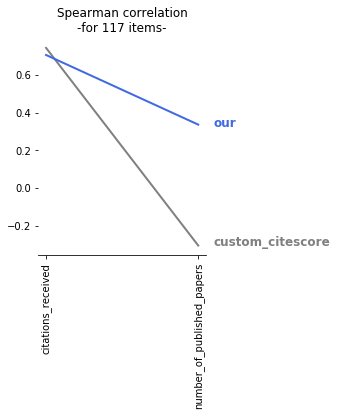

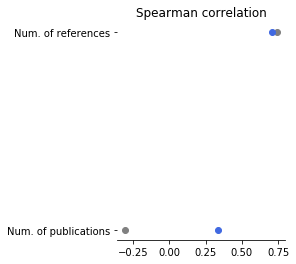

,feature,score,value
0,citations_received,custom_citescore,0.743915
1,citations_received,param,0.706262
2,number_of_published_papers,custom_citescore,-0.304478
3,number_of_published_papers,param,0.336856


In [61]:
print("Spearman correlation with custom Impact Factor:",
      score_venues.dropna()["param"].corr(score_venues.dropna()["custom_citescore"], method='spearman'))
res = []
for item_1 in ["citations_received", "number_of_published_papers"]:
    for item_2 in ["custom_citescore", "param"]:
        tmp_local = score_venues.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_venues.dropna()))
plot_correlations(pd.DataFrame(get_correlations_dict_venues(score_venues)).sort_values(by="feature"))

total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict_venues(score_venues)))
pd.DataFrame(res)

## Analyze topics

In [128]:
topic_threshold = 0.2
field_name = "topics"

experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name


'scipub_minimal_venus-experiment-2000_2004-2005_2014-topics'

### Considering the 50 items having at least one parameter

MAX: {'experiment': '5 - 3', 'mean': 0.972095504868614, 'std': 0.03126463415807723, 'time_window_size': 5, 'overlap': 3}


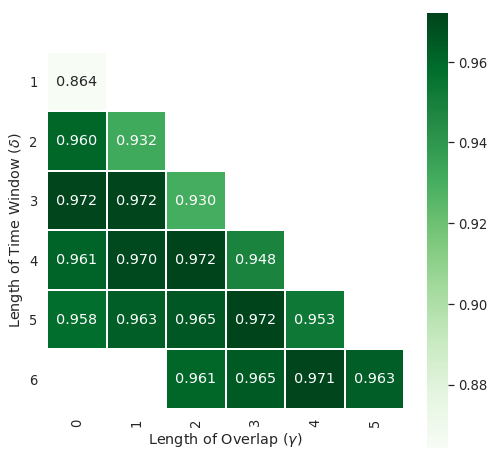

In [129]:
correlations = TW_correlations(field_name, client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp)
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".jpg")


In [64]:
score_topics = get_score_topics(field_name, topic_threshold, best_parameters, __db_name, main_collection_name, experiment_collection_name)


In [65]:
print("Top Topics according to our method")
score_topics.sort_values(by="param", ascending=False)[:25]


Top Topics according to our method


,topics,param,citations_received,publications_initial,publications_other,diffusion
0,19,11893.500000,21612,2170,13231,2078.896967
1,42,10793.999981,8265,2097,7913,1580.454545
2,36,9356.000008,4707,1212,6833,1407.248484
3,43,9287.999992,15268,2471,8969,1276.666666
4,26,8972.000016,14648,1294,6874,946.048486
5,41,8050.499986,8106,1034,3413,548.406061
6,7,8027.000010,4053,1240,4072,726.333334
7,6,7825.499964,3993,1291,4423,960.836363
8,12,7804.000006,2812,827,3936,857.406061
9,46,7771.999994,3679,271,1073,246.406060


In [66]:
print("Top Topics according diffusion")
score_topics.sort_values(by="diffusion", ascending=False)[:25]


Top Topics according diffusion


,topics,param,citations_received,publications_initial,publications_other,diffusion
0,19,11893.500000,21612,2170,13231,2078.896967
1,42,10793.999981,8265,2097,7913,1580.454545
2,36,9356.000008,4707,1212,6833,1407.248484
15,48,6770.500006,7884,2567,8646,1335.381820
3,43,9287.999992,15268,2471,8969,1276.666666
22,10,5525.499990,2813,1652,4724,1115.654544
13,15,7005.000008,2853,619,3682,1026.078788
33,14,3413.999998,1770,1181,4000,996.187880
7,6,7825.499964,3993,1291,4423,960.836363
4,26,8972.000016,14648,1294,6874,946.048486


Spearman correlation with diffusion: 0.7515486194477791


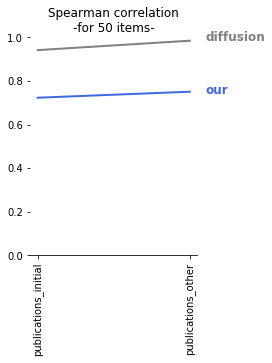

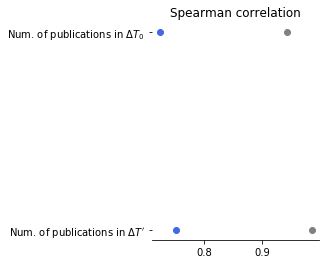

,feature,score,value
0,publications_initial,diffusion,0.941705
1,publications_initial,param,0.723217
2,publications_other,diffusion,0.984826
3,publications_other,param,0.750780


In [67]:
print("Spearman correlation with diffusion:",
      score_topics.dropna()["param"].corr(score_topics.dropna()["diffusion"], method='spearman'))
res = []
for item_1 in ["publications_initial", "publications_other"]:
    for item_2 in ["diffusion", "param"]:
        tmp_local = score_topics.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_topics.dropna()))
plot_correlations(pd.DataFrame(get_correlations_dict_topics(score_topics)).sort_values(by="feature"))

total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict_topics(score_topics)))
pd.DataFrame(res)


## Overview

In [74]:
#total_correlations[total_correlations["score"] != "param"]
total_correlations.loc[total_correlations.iloc[:,total_correlations.columns.tolist().index("score")] != "param", "score"] = "baseline"
total_correlations = total_correlations.reset_index(drop=True)
total_correlations


,feature,item,score,value
0,Range of years,Authors,baseline,0.692261
1,Range of years,Authors,param,0.243743
2,Num. of publications,Authors,baseline,0.834809
3,Num. of publications,Authors,param,0.307590
4,g-index,Authors,baseline,0.925192
5,g-index,Authors,param,0.492751
6,m-index,Authors,baseline,0.466618
7,m-index,Authors,param,0.636667
8,i10-index,Authors,baseline,0.639563
9,i10-index,Authors,param,0.627318


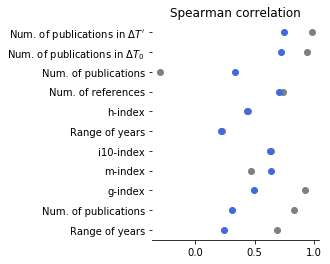

In [75]:
plot_correlations(total_correlations)

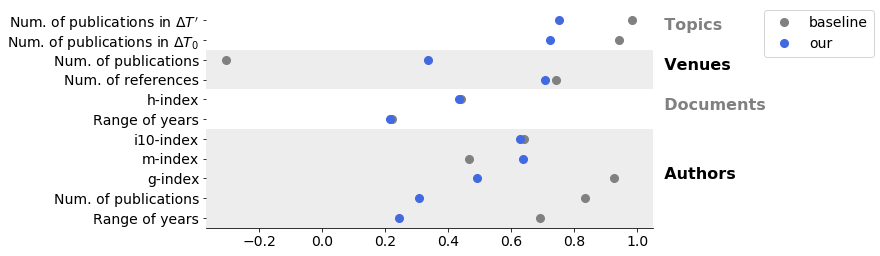

In [98]:
plot_correlations_2(total_correlations, vertical=False, filename=RESULTS_DIR+"/correlations_overview.jpg")

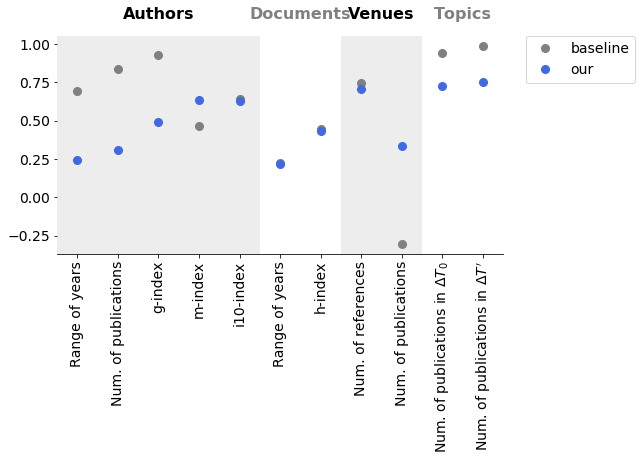

In [97]:
plot_correlations_2(total_correlations, filename=RESULTS_DIR+"/correlations_overview-hor.eps")